# chips-net analysis

This notebook contains the full analysis of chipsnet showing the full path taken to the current final version...

- [x] Exploring the data: looking at the truth distributions and event image representations.
- [x] Quality cuts: how to simply remove background.
- [x] Which event image representation is best? 
- [x] Which training sample is best? (beam flux vs uniform)
- [ ] Different model architectures: which works best.
- [ ] Trying a multi-task model: what to include.
- [ ] Model calibration sensitivity: can we shift things up and down?
- [ ] Neutrino energy estimation: which model to use.
- [x] Explanation: unsupervised category clustering, activations and expected behavoir (energy dependence).
- [ ] Can we determine the primary particles?
- [ ] Final model/models performance and comparison with lagacy reco and PID

In [1]:
# Default input parameters for this notebook, they are overridden by 'papermill' at runtime if specified
config_path = "../config/eval.yaml"
save_path = "../data/output/"
nuel_map_file = "/unix/chips/jtingey/production/beam_all/nuel/map/chips_1200/selected_000_sim_map.root"
numu_map_file = "/unix/chips/jtingey/production/beam_all/numu/map/chips_1200/selected_000_sim_map.root"
cosmic_map_file = "/unix/chips/jtingey/production/cosmic_all/map/chips_1200/selected_000_sim_map.root"

In [2]:
# Standard inports
import os
import logging
import importlib

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mplhep as hep

# Setup Tensorflow with correct logging and GPU's for inference
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.disable(logging.CRITICAL)
gpus = tf.config.list_physical_devices('GPU')
if tf.config.list_physical_devices('GPU'):
    try:  # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:  # Memory growth must be set before GPUs have been initialized
        print(e)

import chipsnet.config
import chipsnet.data
import chipsnet.models
import chipsnet.utils

# Setup matplotlib style using mplhep
extra_styling = {
    "text.usetex": True,
    "pgf.texsystem": "pdflatex",
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.serif": "Computer Modern Roman",
    "axes.xmargin": 0
}
plt.style.use([hep.style.ROOT, extra_styling])

In [3]:
# Reload method to import chipsnet modules on the fly if changes are made to them
def reload():
    importlib.reload(chipsnet.config)
    importlib.reload(chipsnet.data)
    importlib.reload(chipsnet.models)
    importlib.reload(chipsnet.utils)
    
def save(name):
    plt.savefig('{}{}.pgf'.format(save_path, name))
    plt.savefig('{}{}.pdf'.format(save_path, name))
    plt.show()   

## Load data/models and run inference

We run all data loading and model inference now. This takes a while...

In [4]:
config = chipsnet.config.get(config_path)
v_c_flux_ev, v_c_flux_out = chipsnet.utils.process_ds(config, "v_c_flux", ["t_all_cat_v_c_uniform"])
v_ct_flux_ev, v_ct_flux_out = chipsnet.utils.process_ds(config, "v_ct_flux", ["t_all_cat_v_ct_uniform"])
o_ct_flux_ev, o_ct_flux_out = chipsnet.utils.process_ds(config, "o_ct_flux", ["t_all_cat_o_ct_uniform"])
i_ct_flux_ev, i_ct_flux_out = chipsnet.utils.process_ds(config, "i_ct_flux", ["t_all_cat_i_ct_uniform"])

v_cth_flux_ev, v_cth_flux_out = chipsnet.utils.process_ds(config,"v_cth_flux", ["t_all_cat_v_cth_uniform", "t_all_cat_v_cth_flux", "t_cos_cat_v_cth_uniform"])
v_cth_uniform_ev, v_cth_uniform_out = chipsnet.utils.process_ds(config, "v_cth_uniform", ["t_all_cat_v_cth_uniform"])

v_cth_flux_cos_ev, v_cth_flux_cos_out = chipsnet.utils.process_ds(config, "v_cth_flux_cos", ["t_cos_cat_v_cth_flux", "t_cos_cat_v_cth_uniform"])
v_cth_uniform_cos_ev, v_cth_uniform_cos_out = chipsnet.utils.process_ds(config, "v_cth_uniform_cos", ["t_cos_cat_v_cth_uniform"])

Processing v_c_flux... took 89.52 seconds
Processing v_ct_flux... took 86.30 seconds
Processing o_ct_flux... took 85.63 seconds
Processing i_ct_flux... took 85.52 seconds
Processing v_cth_flux... Nuel:   16402, weight: 0.00237, actual: 38.88
Anuel:  16128, weight: 0.00016, actual: 2.53
Numu:   15959, weight: 0.21011, actual: 3353.22
Anumu:  15511, weight: 0.00473, actual: 73.36
Cosmic: 0, weight: 0.000, actual: 1210697.86
Nuel-CC: total 27507, survived: 0.9279456138437489
Numu-CC: total 27227, survived: 0.7550960443677233
NC: total 9266, survived: 0.4082667817828621
              precision    recall  f1-score   support

     nuel-cc       0.92      0.90      0.91     27507
     numu-cc       0.98      0.93      0.95     27227
          nc       0.66      0.82      0.73      9266

    accuracy                           0.90     64000
   macro avg       0.85      0.88      0.86     64000
weighted avg       0.91      0.90      0.90     64000

Nuel-CC: 0.2869(0.8900)
Numu-CC: 0.7047(0.0450

## Exploring the data: looking at the truth distributions and event image representations.

First let's explore the input data we have to work with...

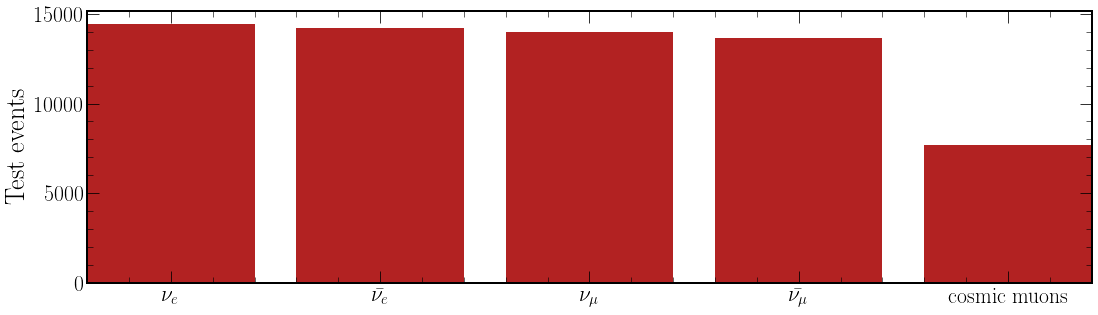

In [5]:
# change variable name for dataframes to make everything easier
events_u = v_cth_uniform_cos_ev  
events_b = v_cth_flux_cos_ev

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
cats = np.arange(5)
axs.bar(
    cats, 
    [len(events_b[(events_b.t_nu_type == 0) & (events_b.t_sign_type == 0) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 0) & (events_b.t_sign_type == 1) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 1) & (events_b.t_sign_type == 0) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[(events_b.t_nu_type == 1) & (events_b.t_sign_type == 1) & (events_b.t_cosmic_cat == 0)]), 
     len(events_b[events_b.t_cosmic_cat == 1])],
    color="firebrick")
axs.set_xticks(cats)
axs.set_xticklabels(('$\\nu_{e}$', '$\\bar{\\nu_{e}}$', '$\\nu_{\mu}$', '$\\bar{\\nu_{\mu}}$', 'cosmic muons'))
axs.set_ylabel("Test events")
save("nu_types")

In [6]:
def plot_cats(events_u, events_b, cat_map):
    data_u = [len(events_u[events_u[cat_map["name"]] == i]) for i in range(len(cat_map["labels"]))]
    data_b = [len(events_b[events_b[cat_map["name"]] == i]) for i in range(len(cat_map["labels"]))]
    cats = np.arange(len(cat_map["labels"]))
    width = 0.45

    fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
    axs.bar(cats+width/2, data_u, color="royalblue", width=width, label="uniform sample")
    axs.bar(cats-width/2, data_b, color="firebrick", width=width, label="flux sample")
    axs.set_xticks(cats)
    axs.set_xticklabels(cat_map["labels"], fontsize=14, rotation='vertical')
    axs.set_ylabel("Testing events")
    axs.legend()
    save(cat_map["name"])

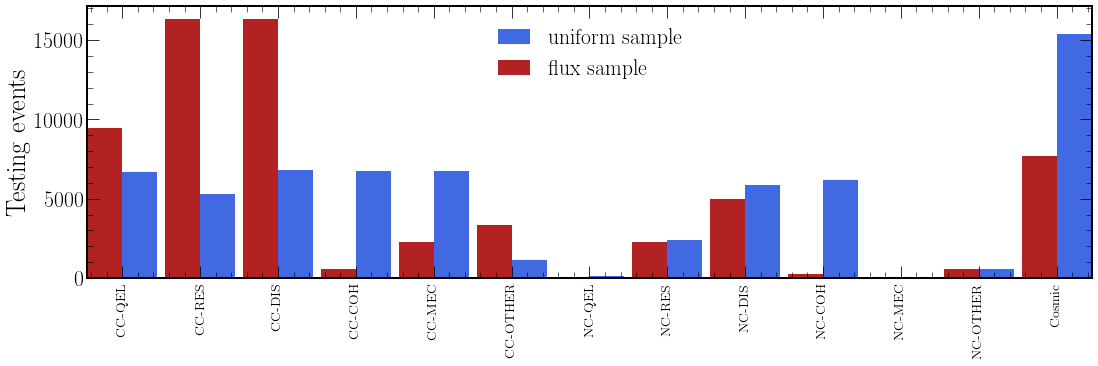

In [7]:
plot_cats(events_u, events_b, chipsnet.data.MAP_INT_TYPE)

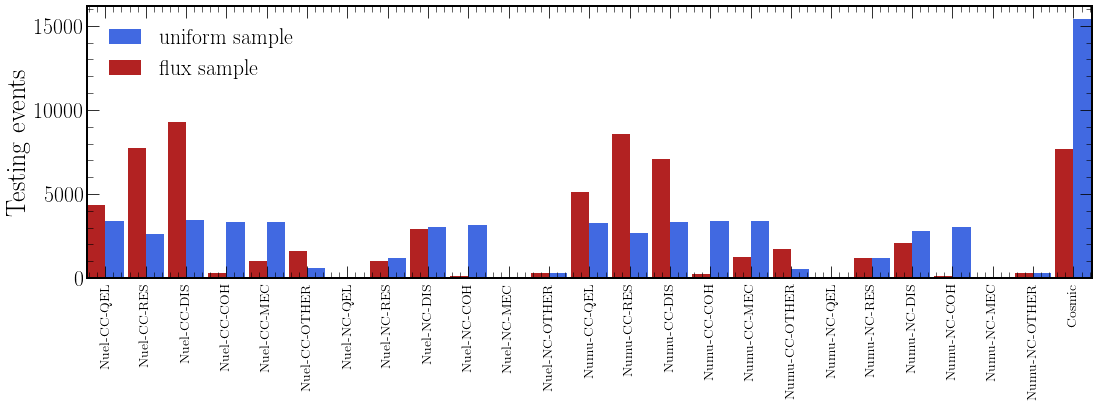

In [8]:
plot_cats(events_u, events_b, chipsnet.data.MAP_ALL_CAT)

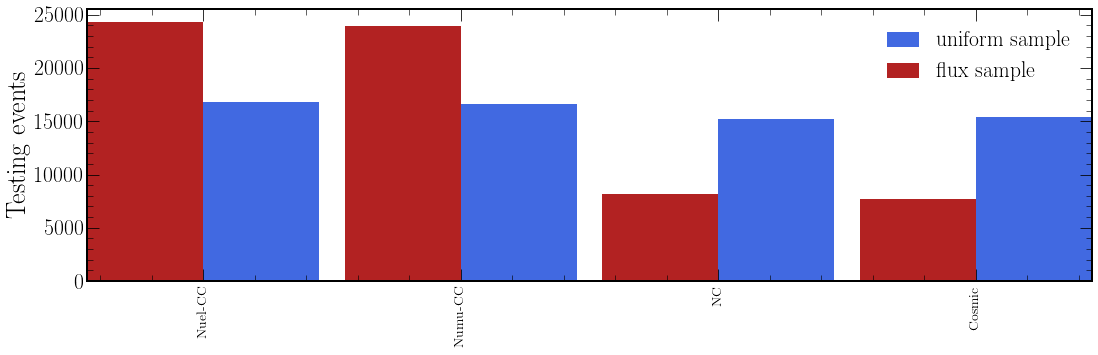

In [9]:
plot_cats(events_u, events_b, chipsnet.data.MAP_FULL_COMB_CAT)

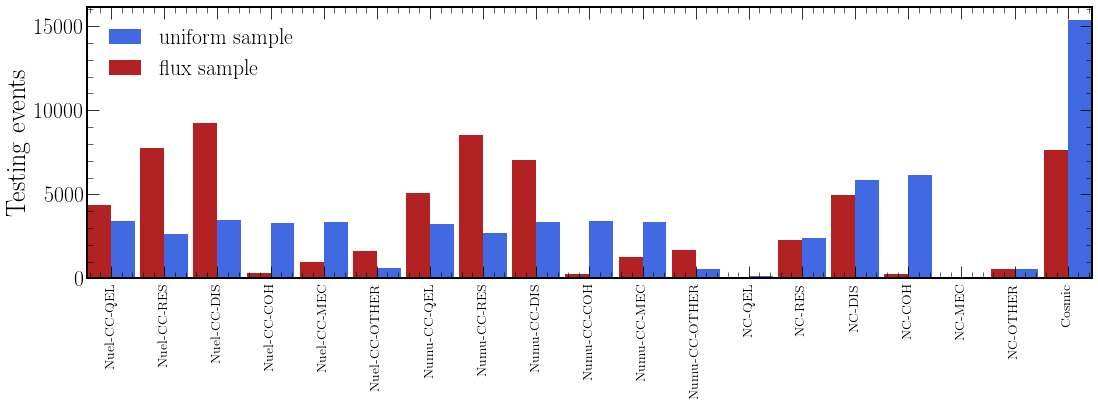

In [10]:
plot_cats(events_u, events_b, chipsnet.data.MAP_NU_NC_COMB_CAT)

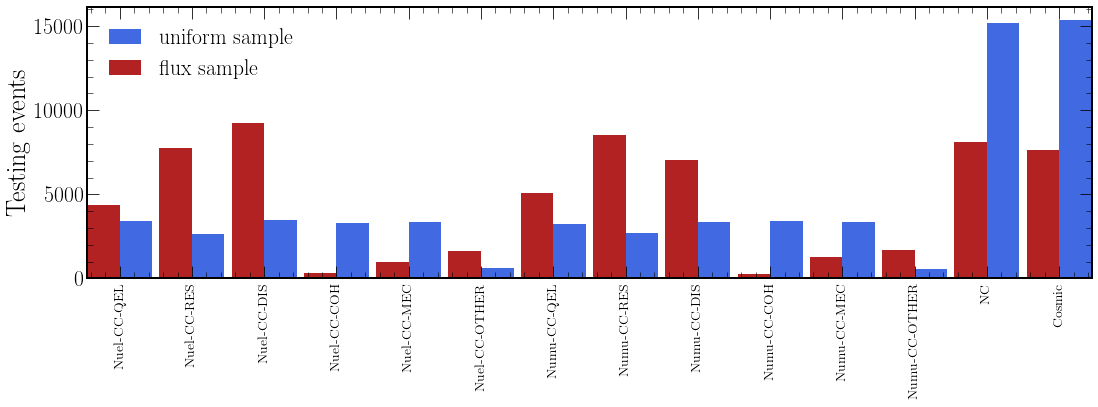

In [11]:
plot_cats(events_u, events_b, chipsnet.data.MAP_NC_COMB_CAT)

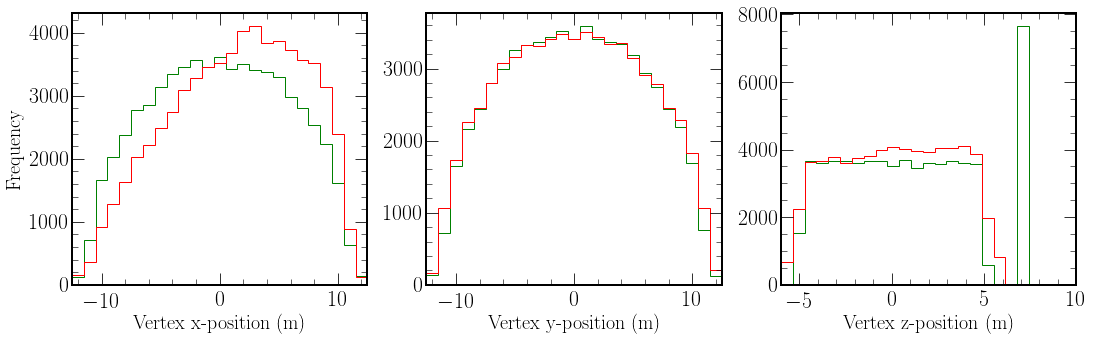

In [12]:
line_g = matplotlib.lines.Line2D([], [], c='green')
line_r = matplotlib.lines.Line2D([], [], c='red')

fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(events_b["t_vtxX"]/100, range=(-12.5, 12.5), bins=25, color='green', histtype='step')
axs[0].hist(events_b["r_vtxX"]*1250/100, range=(-12.5, 12.5), bins=25, color='red', histtype='step')
#axs[0].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[0].set_xlabel('Vertex x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events_b["t_vtxY"]/100, range=(-12.5, 12.5), bins=25, color='green', histtype='step')
axs[1].hist(events_b["r_vtxY"]*1250/100, range=(-12.5, 12.5), bins=25, color='red', histtype='step')
#axs[1].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[1].set_xlabel('Vertex y-position (m)', fontsize=20)

axs[2].hist(events_b["t_vtxZ"]/100, range=(-6, 10), bins=25, color='green', histtype='step')
axs[2].hist(events_b["r_vtxZ"]*600/100, range=(-6, 10), bins=25, color='red', histtype='step')
#axs[2].legend(loc="upper left", handles=[line_g, line_r], labels=["true", "reco"])
axs[2].set_xlabel('Vertex z-position (m)', fontsize=20)
save("vtx_positions")

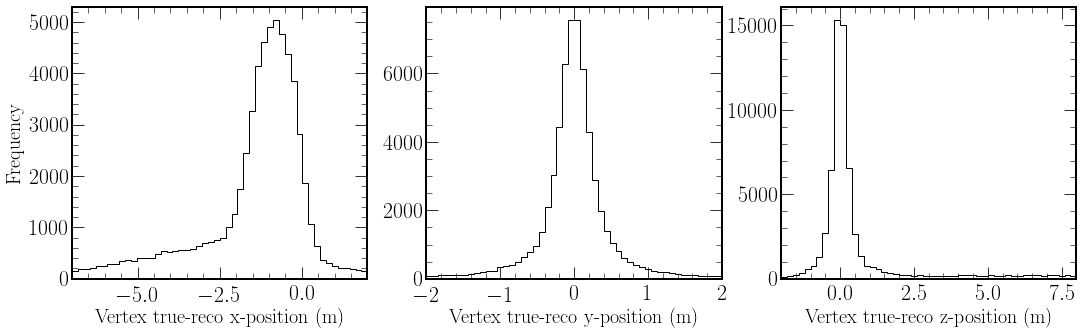

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs[0].hist(events_b["t_vtxX"]/100-(events_b["r_vtxX"]*1250/100), range=(-7, 2), bins=50, color='black', histtype='step')
axs[0].set_xlabel('Vertex true-reco x-position (m)', fontsize=20)
axs[0].set_ylabel('Frequency', fontsize=20)

axs[1].hist(events_b["t_vtxY"]/100-(events_b["r_vtxY"]*1250/100), range=(-2, 2), bins=50, color='black', histtype='step')
axs[1].set_xlabel('Vertex true-reco y-position (m)', fontsize=20)

axs[2].hist(events_b["t_vtxZ"]/100-(events_b["r_vtxZ"]*600/100), range=(-2, 8), bins=50, color='black', histtype='step')
axs[2].set_xlabel('Vertex true-reco z-position (m)', fontsize=20)
save("true_reco_vtx")

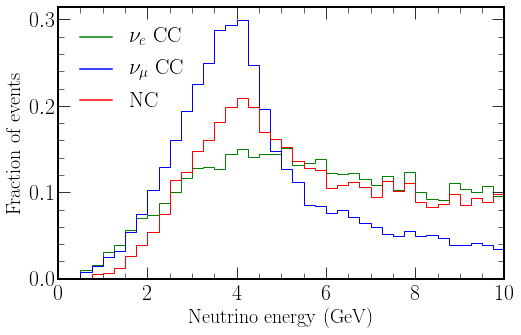

In [14]:
line_g = matplotlib.lines.Line2D([], [], c='green')
line_b = matplotlib.lines.Line2D([], [], c='blue')
line_r = matplotlib.lines.Line2D([], [], c='red')

fig, axs = plt.subplots(1, 1, figsize=(8, 5), gridspec_kw={'hspace': 0.3})
axs.hist(events_b[events_b["t_comb_cat"] == 0]["t_nuEnergy"]/1000, range=(0, 10), bins=40, color='green', histtype='step', density=True)
axs.hist(events_b[events_b["t_comb_cat"] == 1]["t_nuEnergy"]/1000, range=(0, 10), bins=40, color='blue', histtype='step', density=True)
axs.hist(events_b[events_b["t_comb_cat"] == 2]["t_nuEnergy"]/1000, range=(0, 10), bins=40, color='red', histtype='step', density=True)
axs.legend(loc="upper left", handles=[line_g, line_b, line_r], labels=["$\\nu_{e}$ CC", "$\\nu_{\mu}$ CC", "NC"])
axs.set_xlabel('Neutrino energy (GeV)', fontsize=20)
axs.set_ylabel('Fraction of events', fontsize=20)
save("nu_energies")

In [15]:
# Setup an images dictionary to hold example images
image_size = [64, 64]
images_dict = {"r_raw_charge_map_origin": [], "r_raw_charge_map_iso": [], "r_raw_charge_map_vtx": [],
               "r_raw_time_map_origin": [], "r_raw_time_map_iso": [], "r_raw_time_map_vtx": [], "r_raw_hit_hough_map_vtx": []}
channel_hists = images_dict

In [16]:
# Load the images into the dictionary
import uproot
nuel_file = uproot.open(nuel_map_file)
numu_file = uproot.open(numu_map_file)
cosmic_file = uproot.open(cosmic_map_file)
for image_name in images_dict.keys():
    images_dict[image_name].extend(nuel_file['reco'].array(image_name))
    images_dict[image_name].extend(numu_file['reco'].array(image_name))
    images_dict[image_name].extend(cosmic_file['reco'].array(image_name))

# Calculate fraction of hits in the endcaps
cap_total = 0
barrel_total = 0
for event in images_dict['r_raw_charge_map_vtx']:
    sections = np.split(event, [18, 46], axis=0)
    cap_total += (sections[0].sum() + sections[2].sum())
    barrel_total += sections[1].sum()

# This is with cosmic events included
print("Fraction of deposited charge in endcaps = {}".format(cap_total/(cap_total+barrel_total)))

Fraction of deposited charge in endcaps = 0.47705780747902665


In [17]:
def plot_hit_time(images_dict, event):
    fig, axs = plt.subplots(2, 3, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
    plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    axs[0, 0].imshow(images_dict['r_raw_charge_map_origin'][event], cmap='Reds', origin='lower')
    axs[0, 0].set_title('$\phi$ and $\\theta$ from origin')
    axs[0, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')

    axs[0, 1].imshow(images_dict['r_raw_charge_map_iso'][event], cmap='Reds', origin='lower')
    axs[0, 1].set_title('$x^{+}$ and $x^{-}$ from origin')
    axs[0, 1].set(xlabel='$x^{+}$ bins', ylabel='$x^{-}$ bins')

    axs[0, 2].imshow(images_dict['r_raw_charge_map_vtx'][event], cmap='Reds', origin='lower')
    axs[0, 2].set_title('$\phi$ and $\\theta$ from vertex')
    axs[0, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs[0, 2].text(68, 3, 'Desposited charge images', rotation=-90, fontsize=18)

    axs[1, 0].imshow(images_dict['r_raw_time_map_origin'][event], cmap='Reds', origin='lower')
    axs[1, 0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')

    axs[1, 1].imshow(images_dict['r_raw_time_map_iso'][event], cmap='Reds', origin='lower')
    axs[1, 1].set(xlabel='$x^{+}$ bins', ylabel='$x^{-}$ bins')

    axs[1, 2].imshow(images_dict['r_raw_time_map_vtx'][event], cmap='Reds', origin='lower')
    axs[1, 2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs[1, 2].text(68, 10, 'First hit time images', rotation=-90, fontsize=18)
    save("example_image_{}".format(event))

def plot_hough(images_dict, event):
    fig, axs = plt.subplots(1, 1, figsize=(5, 5), gridspec_kw={'hspace': 0.3})
    plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    axs.imshow(images_dict['r_raw_hit_hough_map_vtx'][event], cmap='Reds', origin='lower')
    axs.set_title('$\phi$ and $\\theta$ from vertex')
    axs.set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins')
    axs.text(68, 13, 'Hough space image', rotation=-90, fontsize=18)
    save("example_hough_{}".format(event))

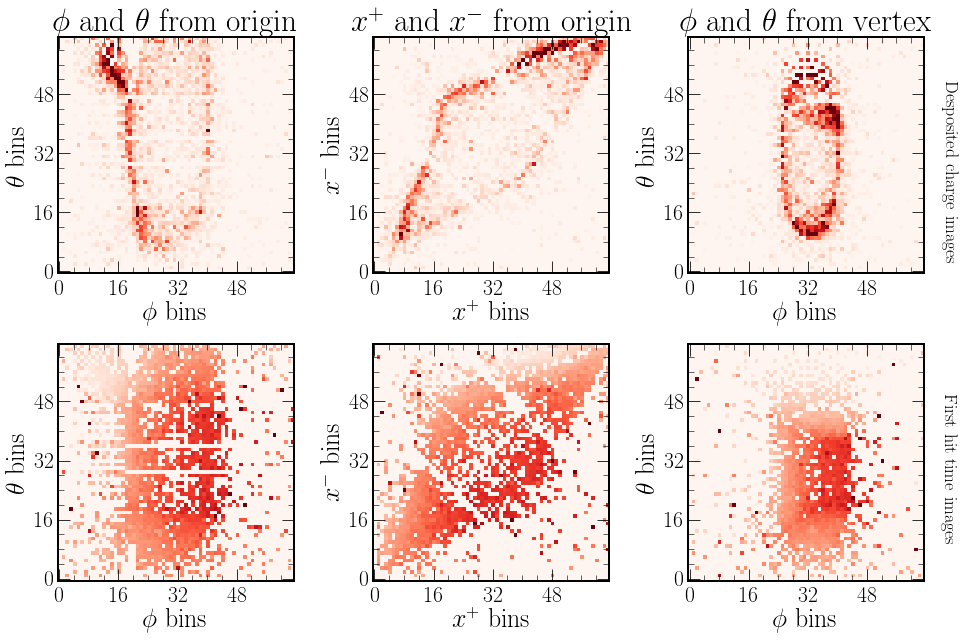

In [18]:
plot_hit_time(images_dict, 1)

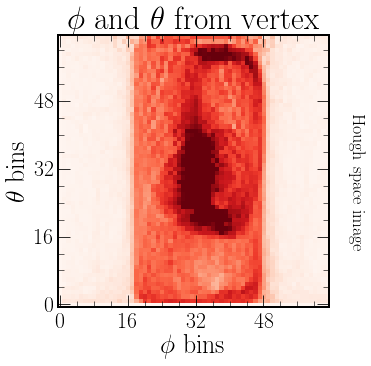

In [19]:
plot_hough(images_dict, 1)

In [20]:
def plot_8bit_range(images_dict, max_charge=30, max_time=130, max_hough=4000):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    #plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
    
    hist_data = []
    for event in images_dict['r_raw_charge_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[0].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[0].set_title("[0,{}], outside range: {:.4f}".format(max_charge, occurrences), fontsize=17)
    axs[0].set(xlabel='Hit charge 8-bit value', ylabel='Frequency')
    axs[0].label_outer()
    
    hist_data = []
    for event in images_dict['r_raw_time_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[1].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[1].set_title("[0,{}], outside range: {:.4f}".format(max_time, occurrences), fontsize=17)
    axs[1].set(xlabel='Hit time 8-bit value', ylabel='Frequency')
    axs[1].label_outer()
    
    hist_data = []
    for event in images_dict['r_raw_hit_hough_map_vtx']:
        hist_data.append(event.reshape(4096))
    hist_data = np.concatenate(hist_data, axis=0)
    occurrences = np.count_nonzero(hist_data == 255)/len(hist_data)
    axs[2].hist(hist_data, range=(1, 256), bins=255, color='grey', histtype='step')
    axs[2].set_title("[0,{}], outside range: {:.4f}".format(max_hough, occurrences), fontsize=17)
    axs[2].set(xlabel='Hough 8-bit value', ylabel='Frequency')
    axs[2].label_outer()
    
    save("8_bit_range")

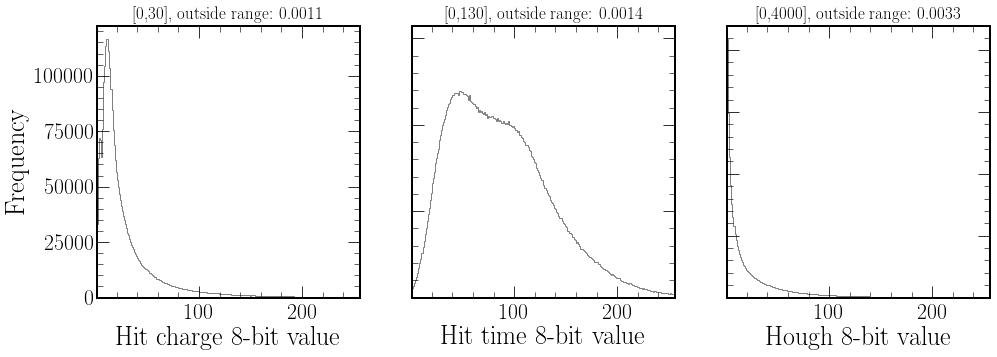

In [21]:
plot_8bit_range(images_dict)

## Quality cuts: how to simply remove background.

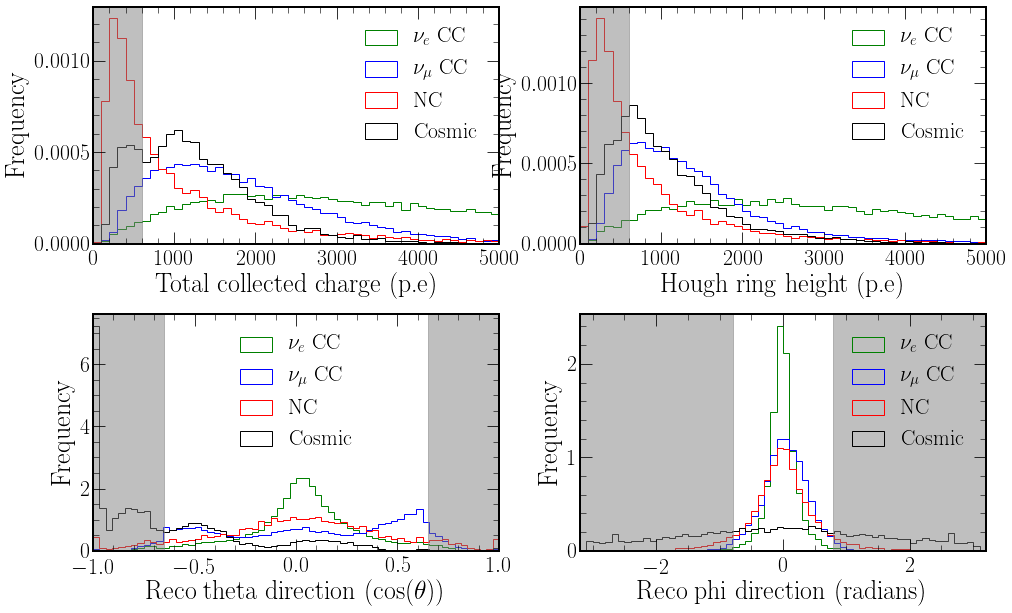

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10), gridspec_kw={'hspace': 0.3})
axs[0, 0].hist(events_b[events_b.t_comb_cat == 0]['r_raw_total_digi_q'], color='green',
               histtype='step', range=(0, 5000), bins=50, density=True, label="$\\nu_{e}$ CC")
axs[0, 0].hist(events_b[events_b.t_comb_cat == 1]['r_raw_total_digi_q'], color='blue', 
               histtype='step', range=(0, 5000), bins=50, density=True, label="$\\nu_{\mu}$ CC")
axs[0, 0].hist(events_b[events_b.t_comb_cat == 2]['r_raw_total_digi_q'], color='red', 
               histtype='step', range=(0, 5000), bins=50, density=True, label="NC")
axs[0, 0].hist(events_b[events_b.t_comb_cat == 3]['r_raw_total_digi_q'], color='black', 
               histtype='step', range=(0, 5000), bins=50, density=True, label="Cosmic")
axs[0, 0].set(xlabel='Total collected charge (p.e)', ylabel='Frequency')
axs[0, 0].axvspan(0, config.eval.cuts.q, alpha=0.5, color='grey')
axs[0, 0].legend()

axs[0, 1].hist(events_b[events_b.t_comb_cat == 0]['r_first_ring_height'], color='green',
               histtype='step', range=(0, 5000), bins=50, density=True, label="$\\nu_{e}$ CC")
axs[0, 1].hist(events_b[events_b.t_comb_cat == 1]['r_first_ring_height'], color='blue', 
               histtype='step', range=(0, 5000), bins=50, density=True, label="$\\nu_{\mu}$ CC")
axs[0, 1].hist(events_b[events_b.t_comb_cat == 2]['r_first_ring_height'], color='red', 
               histtype='step', range=(0, 5000), bins=50, density=True, label="NC")
axs[0, 1].hist(events_b[events_b.t_comb_cat == 3]['r_first_ring_height'], color='black', 
               histtype='step', range=(0, 5000), bins=50, density=True, label="Cosmic")
axs[0, 1].set(xlabel='Hough ring height (p.e)', ylabel='Frequency')
axs[0, 1].axvspan(0, config.eval.cuts.h, alpha=0.5, color='grey')
axs[0, 1].legend()

axs[1, 0].hist(events_b[events_b.t_comb_cat == 0]['r_dirTheta'], color='green',
               histtype='step', range=(-1, 1), bins=64, density=True, label="$\\nu_{e}$ CC")
axs[1, 0].hist(events_b[events_b.t_comb_cat == 1]['r_dirTheta'], color='blue', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="$\\nu_{\mu}$ CC")
axs[1, 0].hist(events_b[events_b.t_comb_cat == 2]['r_dirTheta'], color='red', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="NC")
axs[1, 0].hist(events_b[events_b.t_comb_cat == 3]['r_dirTheta'], color='black', 
               histtype='step', range=(-1, 1), bins=64, density=True, label="Cosmic")
axs[1, 0].set(xlabel='Reco theta direction (cos($\\theta$))', ylabel='Frequency')
axs[1, 0].axvspan(-1, -config.eval.cuts.theta, alpha=0.5, color='grey')
axs[1, 0].axvspan(config.eval.cuts.theta, 1, alpha=0.5, color='grey')
axs[1, 0].legend()

axs[1, 1].hist(events_b[events_b.t_comb_cat == 0]['r_dirPhi']*3.14159, color='green',
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="$\\nu_{e}$ CC")
axs[1, 1].hist(events_b[events_b.t_comb_cat == 1]['r_dirPhi']*3.14159, color='blue', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="$\\nu_{\mu}$ CC")
axs[1, 1].hist(events_b[events_b.t_comb_cat == 2]['r_dirPhi']*3.14159, color='red', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="NC")
axs[1, 1].hist(events_b[events_b.t_comb_cat == 3]['r_dirPhi']*3.14159, color='black', 
               histtype='step', range=(-3.2, 3.2), bins=64, density=True, label="Cosmic")
axs[1, 1].set(xlabel='Reco phi direction (radians)', ylabel='Frequency')
axs[1, 1].axvspan(-3.2, -config.eval.cuts.phi*3.14159, alpha=0.5, color='grey')
axs[1, 1].axvspan(config.eval.cuts.phi*3.14159, 3.2, alpha=0.5, color='grey')
axs[1, 1].legend()
save("simple_cuts")

## Which event image representation is best? 

In [72]:
def plot_combined_values(events, prefix, save_name):
    bins = 25
    range=(0.5, 1)
    cat0 = prefix + "pred_t_comb_cat_0"
    cat1 = prefix + "pred_t_comb_cat_1"
    cat2 = prefix + "pred_t_comb_cat_2"
    nuel_cc_events = events[events["t_comb_cat"] == 0]
    numu_cc_events = events[events["t_comb_cat"] == 1]
    nc_events = events[events["t_comb_cat"] == 2]
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].hist(nuel_cc_events[cat0], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[0].hist(numu_cc_events[cat0], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[0].hist(nc_events[cat0], weights=nc_events["w"], range=range, bins=bins, color='red', histtype='step')
    axs[0].set_xlabel('Combined nuel cc score', fontsize=17)
    axs[0].set_yscale('log')
    
    axs[1].hist(nuel_cc_events[cat1], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[1].hist(numu_cc_events[cat1], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[1].hist(nc_events[cat1], weights=nc_events["w"], range=range, bins=bins, color='red', histtype='step')
    axs[1].set_xlabel('Combined numu cc score', fontsize=17)
    axs[1].set_yscale('log')
    
    axs[2].hist(nuel_cc_events[cat2], weights=nuel_cc_events["w"], range=range, bins=bins, color='green', histtype='step')
    axs[2].hist(numu_cc_events[cat2], weights=numu_cc_events["w"], range=range, bins=bins, color='blue', histtype='step')
    axs[2].hist(nc_events[cat2], weights=nc_events["w"], range=range, bins=bins, color='red', histtype='step')
    axs[2].set_xlabel('Combined nc score', fontsize=17)
    axs[2].set_yscale('log')
    save(save_name)

In [54]:
def plot_curves(events, save_name):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    styles = ["solid", "dashed", "dotted", "dashdot"]
    for i in range(len(events)):
        axs[0].plot(events[i]["cuts"][0], events[i]["sig_effs"][0][0], color='green', linestyle=styles[i])
        axs[0].plot(events[i]["cuts"][0], events[i]["bkg_effs"][0][0], color='red', linestyle=styles[i])
    axs[0].set_xlabel('Combined nuel cc score cut', fontsize=17)
    axs[0].set_ylabel('Efficiency', fontsize=17)

    for i in range(len(events)):
        axs[1].plot(events[i]["cuts"][0], events[i]["purs"][0][0], color='blue', linestyle=styles[i])
        axs[1].plot(events[i]["cuts"][0], events[i]["foms"][0][0], color='black', linestyle=styles[i])
    axs[1].set_xlabel('Combined nuel cc score cut', fontsize=17)
    axs[1].set_ylabel('Purity or FOM', fontsize=17)

    for i in range(len(events)):
        axs[2].plot(events[i]["bkg_effs"][0][0], events[i]["sig_effs"][0][0], color='black', linestyle=styles[i])
    axs[2].set_xlabel('Background efficiency', fontsize=17)
    axs[2].set_ylabel('Signal efficiency', fontsize=17)
    save(save_name)
    
def plot_e_hists(events, save_name):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    bins = np.arange(1000, 8000, 500)
    styles = ["solid", "dashed", "dotted", "dashdot"]
    
    for i in range(len(events)):
        axs[0].plot(bins, events[i]["fom_effs"][0][0][0], color='green', linestyle=styles[i])
        axs[0].plot(bins, events[i]["fom_effs"][0][0][1], color='blue', linestyle=styles[i])
        axs[0].plot(bins, events[i]["fom_effs"][0][0][2], color='red', linestyle=styles[i])
        axs[0].plot(bins, events[i]["fom_purs"][0][0], color='black', linestyle=styles[i])
    axs[0].set_xlabel('Neutrino energy (MeV)', fontsize=17)
    axs[0].set_ylabel('Efficiency', fontsize=17)
    axs[0].set_ylim([0, 1])
    axs[0].set_title('nuel-cc signal')

    for i in range(len(events)):
        axs[1].plot(bins, events[i]["fom_effs"][0][1][0], color='green', linestyle=styles[i])
        axs[1].plot(bins, events[i]["fom_effs"][0][1][1], color='blue', linestyle=styles[i])
        axs[1].plot(bins, events[i]["fom_effs"][0][1][2], color='red', linestyle=styles[i])
        axs[1].plot(bins, events[i]["fom_purs"][0][1], color='black', linestyle=styles[i])
    axs[1].set_xlabel('Neutrino energy (MeV)', fontsize=17)
    axs[1].set_ylim([0, 1])
    axs[1].set_title('numu-cc signal')

    for i in range(len(events)):
        axs[2].plot(bins, events[i]["fom_effs"][0][2][0], color='green', linestyle=styles[i])
        axs[2].plot(bins, events[i]["fom_effs"][0][2][1], color='blue', linestyle=styles[i])
        axs[2].plot(bins, events[i]["fom_effs"][0][2][2], color='red', linestyle=styles[i])
        axs[2].plot(bins, events[i]["fom_purs"][0][2], color='black', linestyle=styles[i])
    axs[2].set_xlabel('Neutrino energy (MeV)', fontsize=17)
    axs[2].set_ylim([0, 1])
    axs[2].set_title('nc signal')
    
    save(save_name)

In [55]:
def plot_history_comparison(config, models, save_name, key="accuracy"):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    for i, model in enumerate(models):
        history = chipsnet.utils.model_history(config, model) 
        epochs = np.arange(1, len(history["loss"])+1)
        axs[i].set_xlabel('epoch', fontsize=17)
        axs[i].set_ylabel(key, color='tab:red', fontsize=17)
        axs[i].plot(epochs, history[key], color='tab:red', linestyle="solid")
        axs[i].plot(epochs, history["val_" + key], color='tab:red', linestyle="dashed")
        axs[i].tick_params(axis='y', labelcolor='tab:red')
        axs_t = axs[i].twinx()  # instantiate a second axes that shares the same x-axis
        axs_t.set_ylabel('loss', color='tab:blue', fontsize=17)  # we already handled the x-label with ax1
        axs_t.plot(epochs, history["loss"], color='tab:blue', linestyle="solid")
        axs_t.plot(epochs, history["val_loss"], color='tab:blue', linestyle="dashed")
        axs_t.tick_params(axis='y', labelcolor='tab:blue')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    save(save_name)

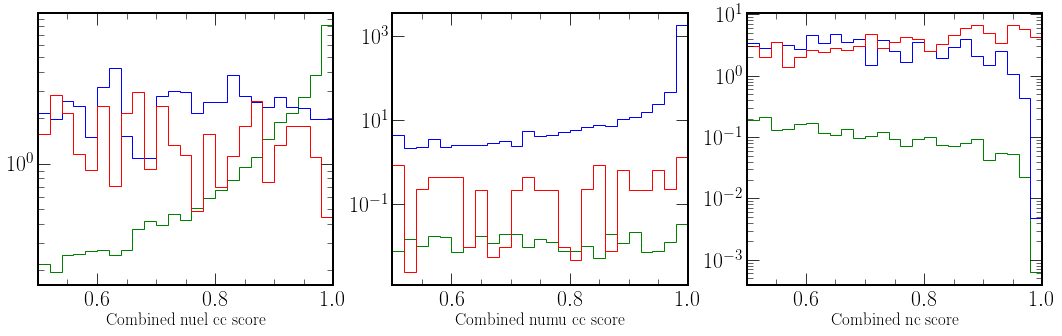

In [75]:
plot_combined_values(v_ct_flux_ev[v_ct_flux_ev["cut"] == 0], "t_all_cat_v_ct_uniform_", "t_all_cat_v_ct_uniform_values")

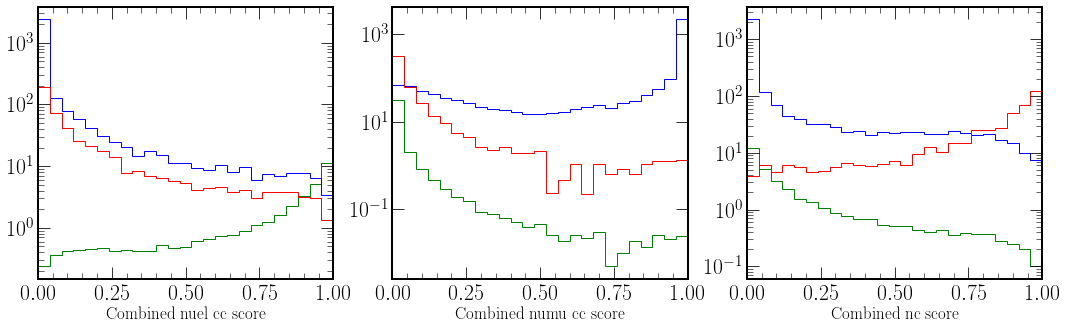

In [57]:
plot_combined_values(o_ct_flux_ev, "t_all_cat_o_ct_uniform_", "t_all_cat_o_ct_uniform_values")

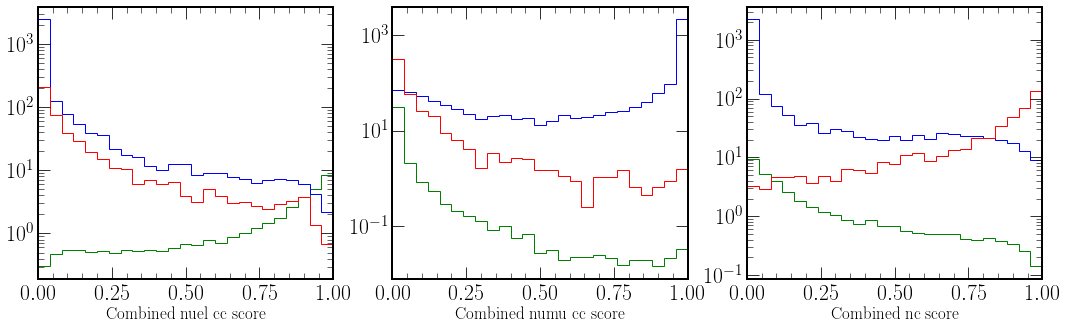

In [58]:
plot_combined_values(i_ct_flux_ev, "t_all_cat_i_ct_uniform_", "t_all_cat_i_ct_uniform_values")

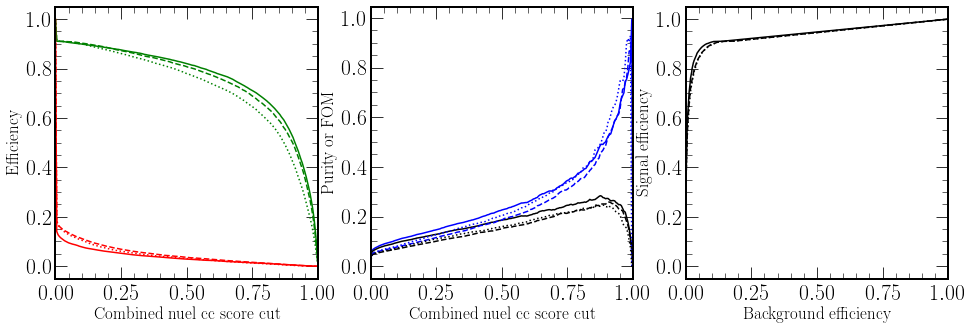

In [59]:
plot_curves([v_ct_flux_out, o_ct_flux_out, i_ct_flux_out], "representation_curves")

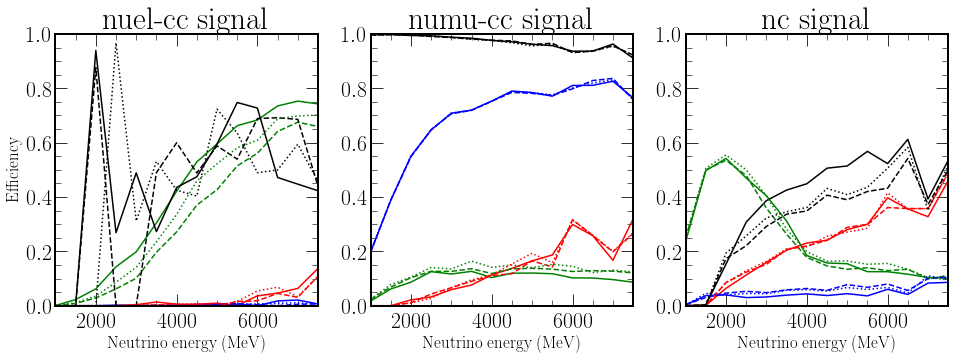

In [60]:
plot_e_hists([v_ct_flux_out, o_ct_flux_out, i_ct_flux_out], "representation_e_hists")

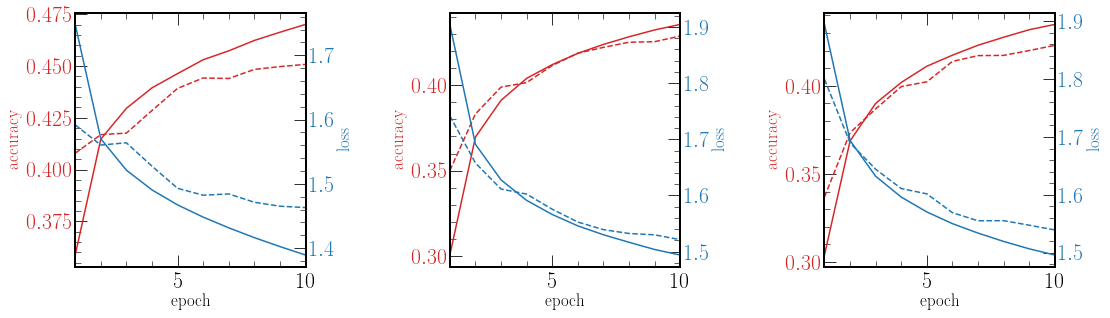

In [61]:
plot_history_comparison(config, ["t_all_cat_v_ct_uniform", "t_all_cat_o_ct_uniform", "t_all_cat_i_ct_uniform"], "representation_history")

In [62]:
print(v_ct_flux_out["sig_effs_auc"])
print(v_ct_flux_out["bkg_effs_auc"])
print(v_ct_flux_out["pur_auc"])
print(v_ct_flux_out["fom_auc"])
print(v_ct_flux_out["roc_auc"])
print(v_ct_flux_out["report"])
print("-------")
print(o_ct_flux_out["sig_effs_auc"])
print(o_ct_flux_out["bkg_effs_auc"])
print(o_ct_flux_out["pur_auc"])
print(o_ct_flux_out["fom_auc"])
print(o_ct_flux_out["roc_auc"])
print(o_ct_flux_out["report"])
print("-------")
print(i_ct_flux_out["sig_effs_auc"])
print(i_ct_flux_out["bkg_effs_auc"])
print(i_ct_flux_out["pur_auc"])
print(i_ct_flux_out["fom_auc"])
print(i_ct_flux_out["roc_auc"])
print(i_ct_flux_out["report"])

[[0.7609004538312197, 0.6786875610373537, 0.1878761236545386]]
[[0.03853958726995582, 0.02778422752523058, 0.031338219957757166]]
[[0.26974867437741745, 0.9911218660445772, 0.5812970663780324]]
[[0.1782432824387524, 0.6741189582181355, 0.09769099873364491]]
[[0.9396847455202972, 0.8324201917951612, 0.5976459621934204]]
['              precision    recall  f1-score   support\n\n     nuel-cc       0.92      0.90      0.91     27507\n     numu-cc       0.98      0.93      0.95     27227\n          nc       0.67      0.81      0.73      9266\n\n    accuracy                           0.90     64000\n   macro avg       0.85      0.88      0.86     64000\nweighted avg       0.91      0.90      0.90     64000\n']
-------
[[0.7489871181708573, 0.6505870191123283, 0.18561887174114095]]
[[0.04981932895489597, 0.026624342542829433, 0.0467071645519578]]
[[0.24116534116702035, 0.991348785586345, 0.4961517286231496]]
[[0.15061069184575204, 0.6462281195743389, 0.07801631458081987]]
[[0.935105853086253

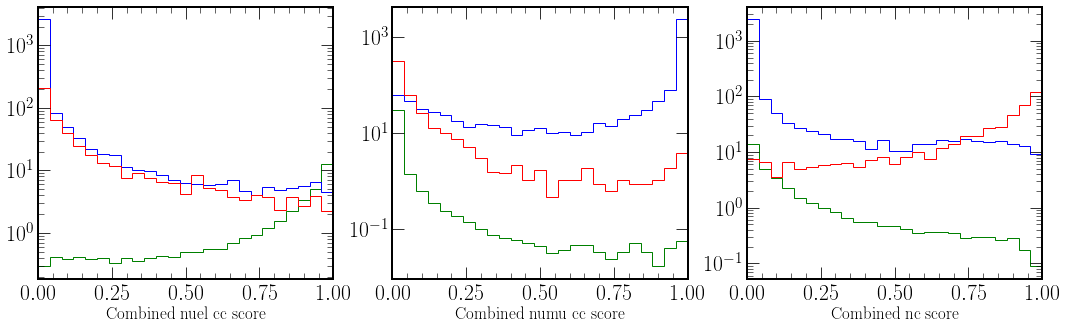

In [63]:
plot_combined_values(v_c_flux_ev, "t_all_cat_v_c_uniform_", "t_all_cat_v_c_uniform_values")

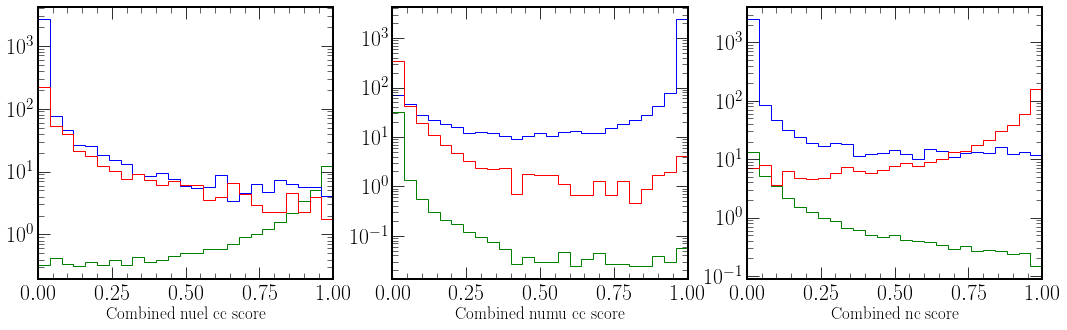

In [64]:
plot_combined_values(v_ct_flux_ev, "t_all_cat_v_ct_uniform_", "t_all_cat_v_ct_uniform_values")

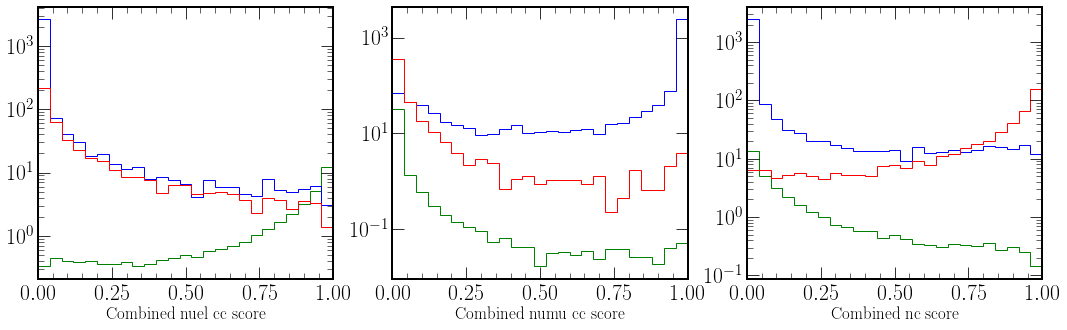

In [65]:
plot_combined_values(v_cth_flux_ev, "t_all_cat_v_cth_uniform_", "t_all_cat_v_cth_uniform_values")

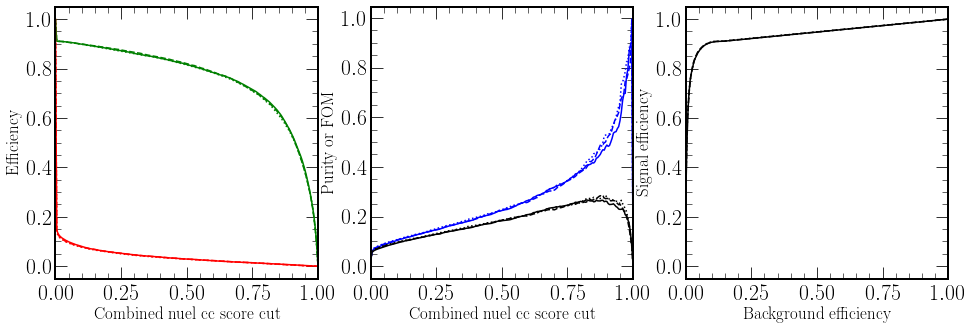

In [66]:
plot_curves([v_c_flux_out, v_ct_flux_out, v_cth_flux_out], "channels_curves")

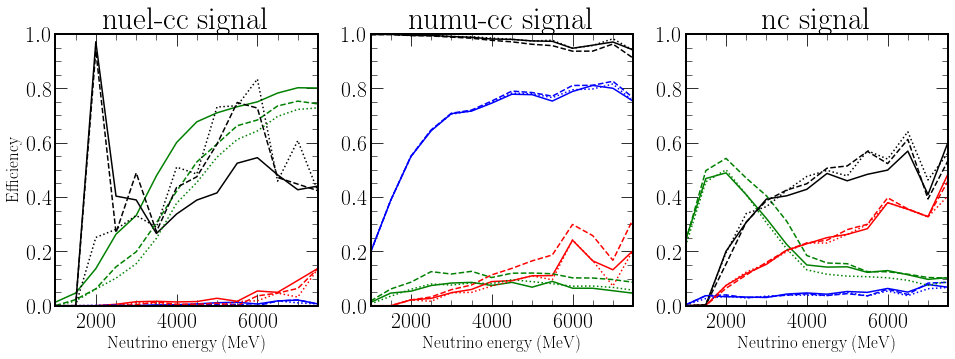

In [67]:
plot_e_hists([v_c_flux_out, v_ct_flux_out, v_cth_flux_out], "channels_e_hists")

In [39]:
print(v_c_flux_out["sig_effs_auc"])
print(v_c_flux_out["bkg_effs_auc"])
print(v_c_flux_out["pur_auc"])
print(v_c_flux_out["fom_auc"])
print(v_c_flux_out["roc_auc"])
print(v_c_flux_out["report"])
print("-------")
print(v_ct_flux_out["sig_effs_auc"])
print(v_ct_flux_out["bkg_effs_auc"])
print(v_ct_flux_out["pur_auc"])
print(v_ct_flux_out["fom_auc"])
print(v_ct_flux_out["roc_auc"])
print(v_ct_flux_out["report"])
print("-------")
print(v_cth_flux_out["sig_effs_auc"])
print(v_cth_flux_out["bkg_effs_auc"])
print(v_cth_flux_out["pur_auc"])
print(v_cth_flux_out["fom_auc"])
print(v_cth_flux_out["roc_auc"])
print(v_cth_flux_out["report"])

[[0.7608186190395432, 0.6753808625380545, 0.1841728314828875]]
[[0.03891021098222464, 0.029365869789878575, 0.03442840760300508]]
[[0.266188763196775, 0.9907666915486784, 0.5630437452802458]]
[[0.1770203622192992, 0.6705603953426263, 0.09021932025571207]]
[[0.9392078874987199, 0.8301876396693401, 0.5914859844827672]]
['              precision    recall  f1-score   support\n\n     nuel-cc       0.92      0.90      0.91     27507\n     numu-cc       0.97      0.92      0.95     27227\n          nc       0.66      0.81      0.73      9266\n\n    accuracy                           0.90     64000\n   macro avg       0.85      0.88      0.86     64000\nweighted avg       0.91      0.90      0.90     64000\n']
-------
[[0.7609004538312197, 0.6786875610373537, 0.1878761236545386]]
[[0.03853958726995582, 0.02778422752523058, 0.031338219957757166]]
[[0.26974867437741745, 0.9911218660445772, 0.5812970663780324]]
[[0.1782432824387524, 0.6741189582181355, 0.09769099873364491]]
[[0.9396847455202972,

## Which training sample is best? (beam flux vs uniform)

In [99]:
def plot_curves_models(events, models, save_name):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'hspace': 0.3})
    styles = ["solid", "dashed", "dotted", "dashdot"]
    for i, model in enumerate(models):
        axs[0].plot(events["cuts"][model], events["sig_effs"][model][0], color='green', linestyle=styles[i])
        axs[0].plot(events["cuts"][model], events["bkg_effs"][model][0], color='red', linestyle=styles[i])
    axs[0].set_xlabel('Combined nuel cc score cut', fontsize=17)
    axs[0].set_ylabel('Efficiency', fontsize=17)

    for i, model in enumerate(models):
        axs[1].plot(events["cuts"][model], events["purs"][model][0], color='blue', linestyle=styles[i])
        axs[1].plot(events["cuts"][model], events["foms"][model][0], color='yellow', linestyle=styles[i])
    axs[1].set_xlabel('Combined nuel cc score cut', fontsize=17)
    axs[1].set_ylabel('Purity or FOM', fontsize=17)

    for i, model in enumerate(models):
        axs[2].plot(events["bkg_effs"][model][0], events["sig_effs"][model][0], color='black', linestyle=styles[i])
    axs[2].set_xlabel('Background efficiency', fontsize=17)
    axs[2].set_ylabel('Signal efficiency', fontsize=17)
    save(save_name)
    
def plot_e_hists_models(events, models, save_name):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5), gridspec_kw={'hspace': 0.3})
    bins = np.arange(1000, 8000, 500)
    styles = ["solid", "dashed", "dotted", "dashdot"]
    
    for i, model in enumerate(models):
        axs[0].plot(bins, events["fom_effs"][model][0][0], color='green', linestyle=styles[i])
        axs[0].plot(bins, events["fom_effs"][model][0][1], color='blue', linestyle=styles[i])
        axs[0].plot(bins, events["fom_effs"][model][0][2], color='red', linestyle=styles[i])
        axs[0].plot(bins, events["fom_purs"][model][0], color='black', linestyle=styles[i])
    axs[0].set_xlabel('Neutrino energy (MeV)', fontsize=17)
    axs[0].set_ylabel('Efficiency', fontsize=17)
    axs[0].set_ylim([0, 1])
    axs[0].set_title('nuel-cc signal')

    for i, model in enumerate(models):
        axs[1].plot(bins, events["fom_effs"][model][1][0], color='green', linestyle=styles[i])
        axs[1].plot(bins, events["fom_effs"][model][1][1], color='blue', linestyle=styles[i])
        axs[1].plot(bins, events["fom_effs"][model][1][2], color='red', linestyle=styles[i])
        axs[1].plot(bins, events["fom_purs"][model][1], color='black', linestyle=styles[i])
    axs[1].set_xlabel('Neutrino energy (MeV)', fontsize=17)
    axs[1].set_ylim([0, 1])
    axs[1].set_title('numu-cc signal')

    for i, model in enumerate(models):
        axs[2].plot(bins, events["fom_effs"][model][2][0], color='green', linestyle=styles[i])
        axs[2].plot(bins, events["fom_effs"][model][2][1], color='blue', linestyle=styles[i])
        axs[2].plot(bins, events["fom_effs"][model][2][2], color='red', linestyle=styles[i])
        axs[2].plot(bins, events["fom_purs"][model][2], color='black', linestyle=styles[i])
    axs[2].set_xlabel('Neutrino energy (MeV)', fontsize=17)
    axs[2].set_ylim([0, 1])
    axs[2].set_title('nc signal')
    
    save(save_name)

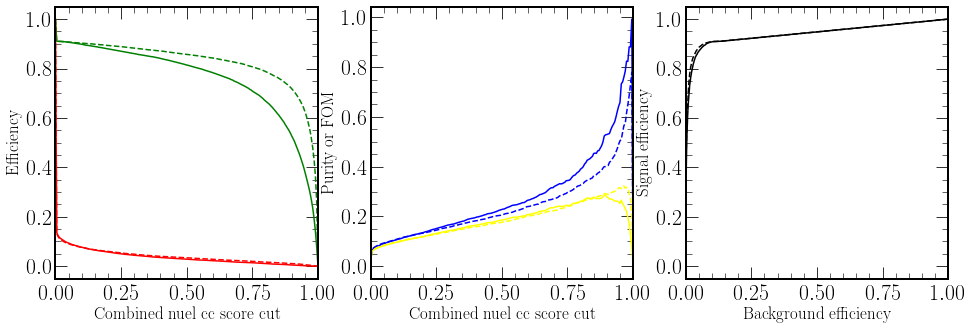

In [100]:
plot_curves_models(v_cth_flux_out, [0, 1], "uniform_vs_flux_curves")

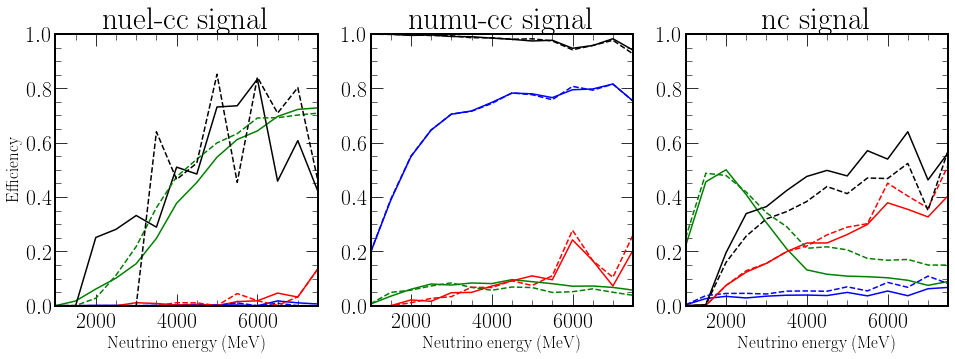

In [101]:
plot_e_hists_models(v_cth_flux_out, [0, 1], "uniform_vs_flux_e_hists")

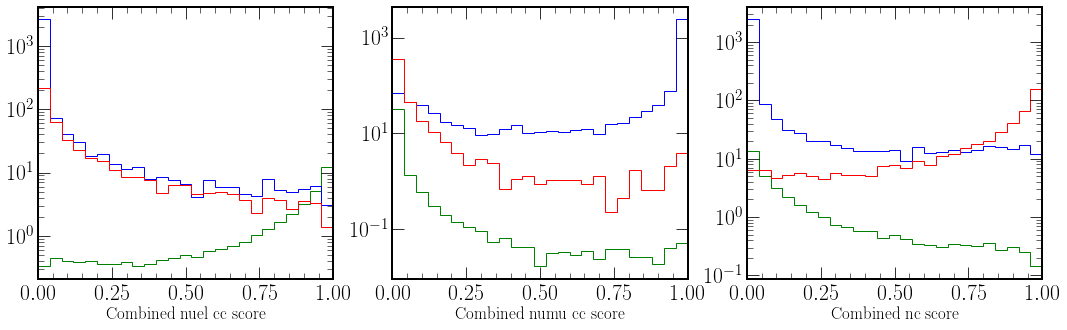

In [82]:
plot_combined_values(v_cth_flux_ev, "t_all_cat_v_cth_uniform_", "t_all_cat_v_cth_uniform_values")

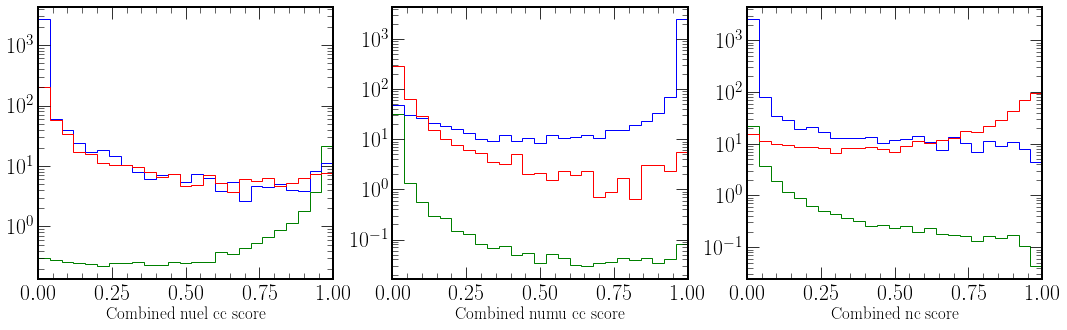

In [83]:
plot_combined_values(v_cth_flux_ev, "t_all_cat_v_cth_flux_", "t_all_cat_v_cth_flux_values")

In [85]:
print(v_cth_flux_out["sig_effs_auc"])
print(v_cth_flux_out["bkg_effs_auc"])
print(v_cth_flux_out["pur_auc"])
print(v_cth_flux_out["fom_auc"])
print(v_cth_flux_out["roc_auc"])
print(v_cth_flux_out["report"])

[[0.7576326920677663, 0.6769078782229792, 0.19193523584790767], [0.8257818421874631, 0.6846322860840156, 0.14982892297036443]]
[[0.037556909000351635, 0.02517279990284644, 0.0340585413193601], [0.04134524363484959, 0.0362635669396107, 0.02600694427957008]]
[[0.2765406633546147, 0.9917426405440533, 0.5635542461823146], [0.23762566112545008, 0.9891635523063442, 0.5804028974112777]]
[[0.18123179787336335, 0.6727742530666685, 0.09617765454937532], [0.18440225250128867, 0.6786652291057153, 0.07602000076140897]]
[[0.9399861009873512, 0.8325817919519726, 0.5952331951835015], [0.9419612972535806, 0.8307358904007384, 0.6005510153858129]]
['              precision    recall  f1-score   support\n\n     nuel-cc       0.92      0.90      0.91     27507\n     numu-cc       0.98      0.93      0.95     27227\n          nc       0.66      0.82      0.73      9266\n\n    accuracy                           0.90     64000\n   macro avg       0.85      0.88      0.86     64000\nweighted avg       0.91    

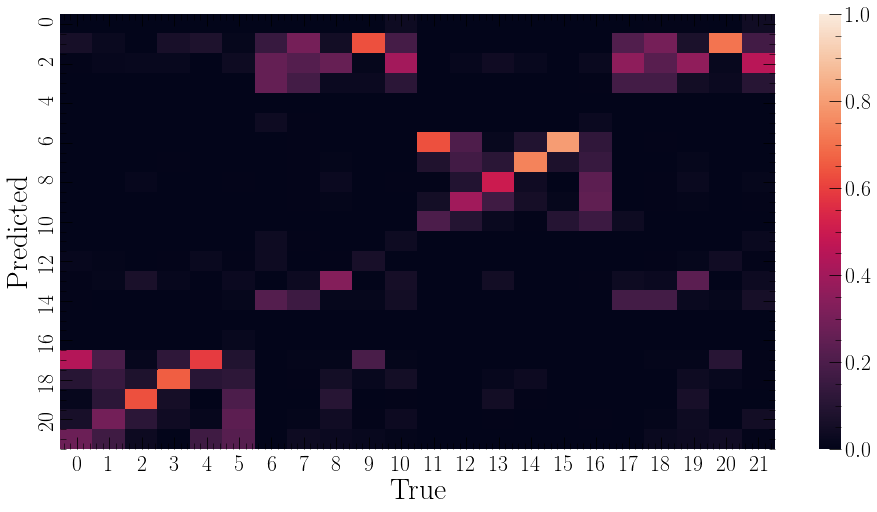

In [102]:
plt.figure(figsize=(16,8))
sns.heatmap(v_cth_flux_out["all_matrices"][0], annot=False, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for uniform sample

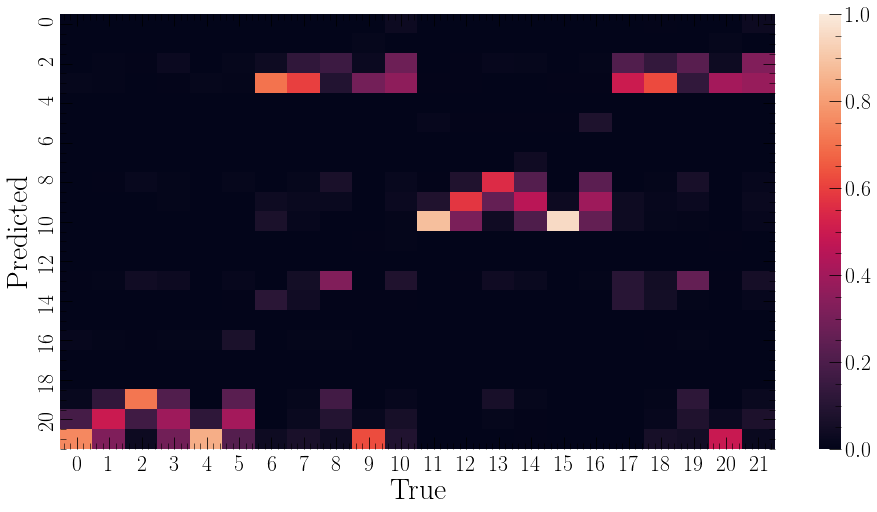

In [103]:
plt.figure(figsize=(16,8))
sns.heatmap(v_cth_flux_out["all_matrices"][1], annot=False, vmin=0.0, vmax=1.0); plt.xlabel('True', fontsize = 30); plt.ylabel('Predicted', fontsize = 30)
plt.show() # Fully combined category confusion matrix for uniform sample

## Different model architectures: which works best.

## Trying a multi-task model: what to include.

## Model calibration sensitivity: can we shift things up and down?

## Neutrino energy estimation: which model to use.

## Explanation: unsupervised category clustering, activations and expected behavoir (energy dependence).

Explained variation per principal component: [0.1552221  0.13005276]


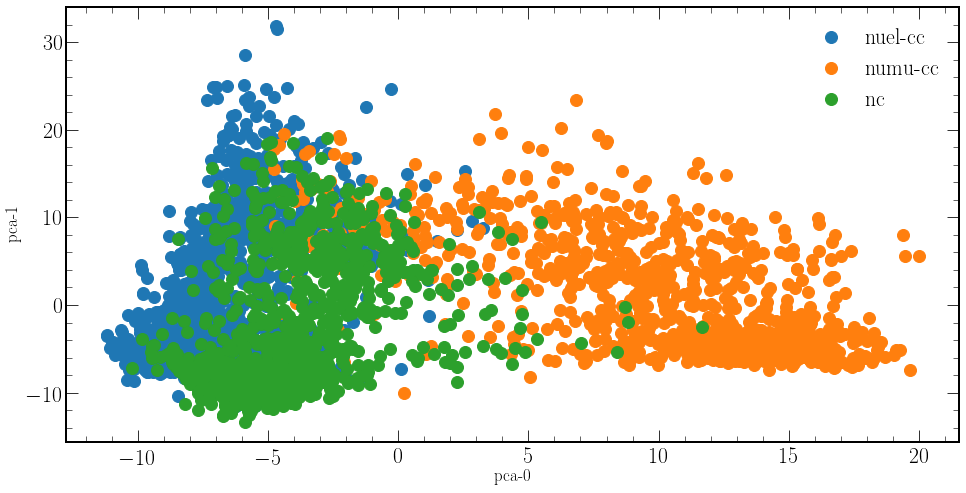

In [50]:
pca_model = chipsnet.utils.model_from_conf(config, "t_all_cat_v_cth_uniform")
v_cth_uniform_ev = chipsnet.utils.run_pca(v_cth_uniform_ev, pca_model, verbose=True, components=2, standardise=True)
cat_0_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 0]
cat_1_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 1]
cat_2_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 2]

fig, axs = plt.subplots(1, 1, figsize=(16, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.pca_0, cat_0_ev.pca_1, marker='o', linestyle='', ms=12, label="nuel-cc")
axs.plot(cat_1_ev.pca_0, cat_1_ev.pca_1, marker='o', linestyle='', ms=12, label="numu-cc")
axs.plot(cat_2_ev.pca_0, cat_2_ev.pca_1, marker='o', linestyle='', ms=12, label="nc")
axs.legend()
axs.set_xlabel('pca-0', fontsize=17)
axs.set_ylabel('pca-1', fontsize=17)
save("pca")

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3200 samples in 0.280s...
[t-SNE] Computed neighbors for 3200 samples in 14.924s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3200
[t-SNE] Computed conditional probabilities for sample 2000 / 3200
[t-SNE] Computed conditional probabilities for sample 3000 / 3200
[t-SNE] Computed conditional probabilities for sample 3200 / 3200
[t-SNE] Mean sigma: 4.962878
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.755638
[t-SNE] KL divergence after 300 iterations: 1.418148


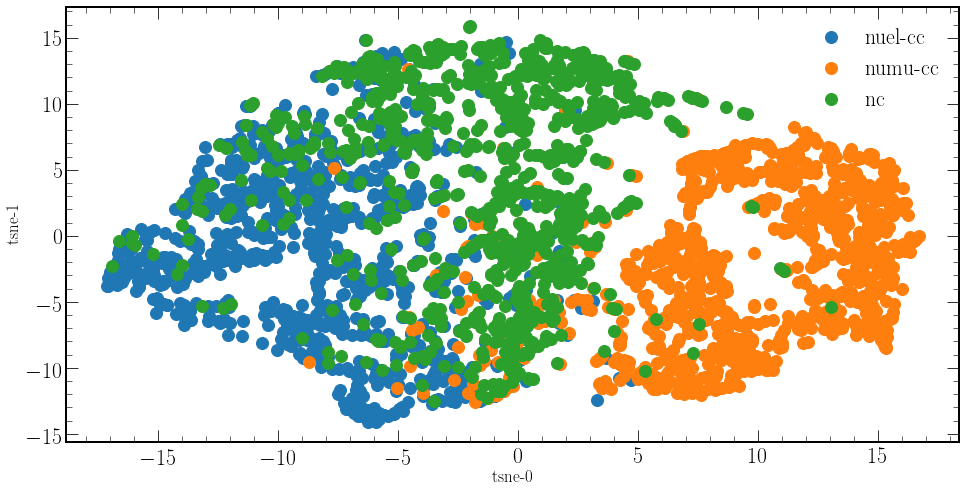

In [51]:
tsne_model = chipsnet.utils.model_from_conf(config, "t_all_cat_v_cth_uniform")
v_cth_uniform_ev = chipsnet.utils.run_tsne(v_cth_uniform_ev, tsne_model, components=2, standardise=True, max_events=10000)
cat_0_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 0]
cat_1_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 1]
cat_2_ev = v_cth_uniform_ev[v_cth_uniform_ev.t_comb_cat == 2]

fig, axs = plt.subplots(1, 1, figsize=(16, 8))
axs.margins(0.05) # Optional, just adds 5% padding to the autoscaling
axs.plot(cat_0_ev.tsne_0, cat_0_ev.tsne_1, marker='o', linestyle='', ms=12, label="nuel-cc")
axs.plot(cat_1_ev.tsne_0, cat_1_ev.tsne_1, marker='o', linestyle='', ms=12, label="numu-cc")
axs.plot(cat_2_ev.tsne_0, cat_2_ev.tsne_1, marker='o', linestyle='', ms=12, label="nc")
axs.legend()
axs.set_xlabel('tsne-0', fontsize=17)
axs.set_ylabel('tsne-1', fontsize=17)
save("tsne")

In [53]:
grad_cam_model = chipsnet.utils.model_from_conf(config, "t_all_cat_v_cth_uniform")
grad_cams_1 = chipsnet.utils.explain_gradcam(v_cth_uniform_ev, grad_cam_model, 10, output="t_all_cat", layer_name="block1_path0_conv1")
grad_cams_2 = chipsnet.utils.explain_gradcam(v_cth_uniform_ev, grad_cam_model, 10, output="t_all_cat", layer_name="block2_conv1")
grad_cams_3 = chipsnet.utils.explain_gradcam(v_cth_uniform_ev, grad_cam_model, 10, output="t_all_cat", layer_name="block3_conv1")

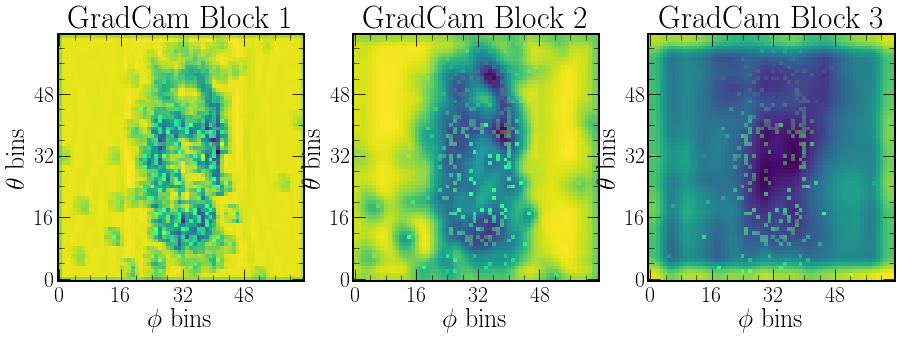

In [54]:
event = 2
fig, axs = plt.subplots(1, 3, figsize=(15, 12), gridspec_kw={'hspace': 0.3})
plt.setp(axs, xticks=[0, 16, 32, 48, 64], yticks=[0, 16, 32, 48, 64])
axs[0].imshow(grad_cams_1[event], cmap='Reds', origin='lower')
axs[0].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 1')
axs[1].imshow(grad_cams_2[event], cmap='Reds', origin='lower')
axs[1].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 2')
axs[2].imshow(grad_cams_3[event], cmap='Reds', origin='lower')
axs[2].set(xlabel='$\phi$ bins', ylabel='$\\theta$ bins', title='GradCam Block 3')
save("grad_cam")

In [55]:
activation_model = chipsnet.utils.model_from_conf(config, "t_all_cat_v_cth_uniform")
activations_1 = chipsnet.utils.explain_activation(v_cth_uniform_ev, activation_model, 10, output="t_all_cat", layer_name="block1_path0_conv1")
activations_2 = chipsnet.utils.explain_activation(v_cth_uniform_ev, activation_model, 10, output="t_all_cat", layer_name="block2_conv1")
activations_3 = chipsnet.utils.explain_activation(v_cth_uniform_ev, activation_model, 10, output="t_all_cat", layer_name="block3_conv1")

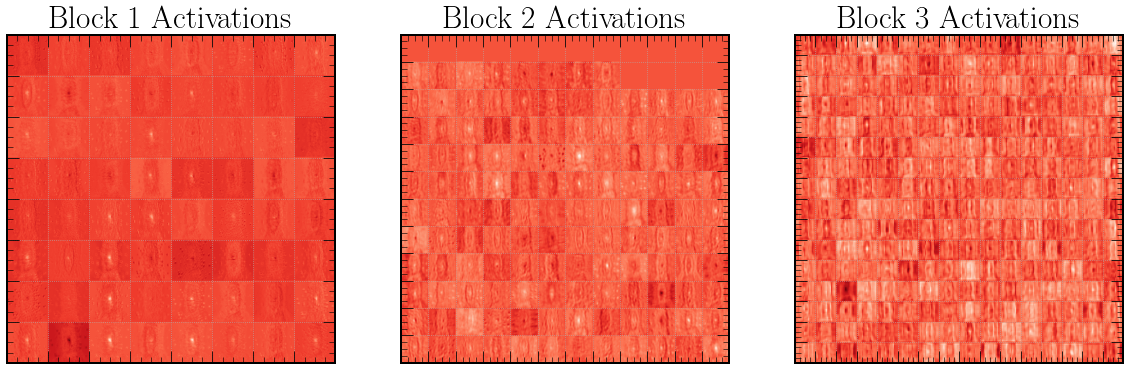

In [56]:
event = 1
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
plt.rc('grid', linestyle="-", color='black')

axs[0].set_xticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_yticks([0, 32, 64, 96, 128, 160, 192, 224, 256])
axs[0].set_xticklabels('')
axs[0].set_yticklabels('')
extent = (0, 256, 256, 0)
axs[0].imshow(activations_1[event], cmap='Reds', origin='lower', extent=extent)
axs[0].set_title('Block 1 Activations')
axs[0].grid()

extent = (0, 192, 192, 0)
axs[1].set_xticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_yticks([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192])
axs[1].set_xticklabels('')
axs[1].set_yticklabels('')
axs[1].imshow(activations_2[event], cmap='Reds', origin='lower', extent=extent)
axs[1].set_title('Block 2 Activations')
axs[1].grid()

extent = (0, 128, 128, 0)
axs[2].set_xticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_yticks([0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128])
axs[2].set_xticklabels('')
axs[2].set_yticklabels('')
axs[2].imshow(activations_3[event], cmap='Reds', origin='lower', extent=extent)
axs[2].set_title('Block 3 Activations')
axs[2].grid()

save("activations")

## Can we determine the primary particles?

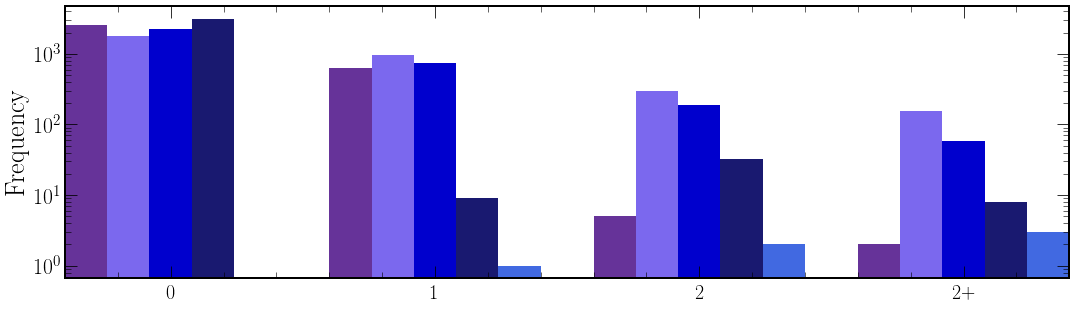

In [57]:
total_data = [len(events_b[events_b["prim_total"] == i]) for i in range(4)]
p_data = [len(events_b[events_b["prim_p"] == i]) for i in range(4)]
cp_data = [len(events_b[events_b["prim_cp"] == i]) for i in range(4)]
np_data = [len(events_b[events_b["prim_np"] == i]) for i in range(4)]
g_data = [len(events_b[events_b["prim_g"] == i]) for i in range(4)]
cats = np.arange(4)
width = 0.8

fig, axs = plt.subplots(1, 1, figsize=(18, 5), gridspec_kw={'hspace': 0.3})
axs.bar(cats-(2*width/5), p_data, color="rebeccapurple", width=width/5)
axs.bar(cats-(width/5), cp_data, color="mediumslateblue", width=width/5)
axs.bar(cats, np_data, color="mediumblue", width=width/5)
axs.bar(cats+(width/5), g_data, color="midnightblue", width=width/5)
axs.bar(cats+(2*width/5), cats, color="royalblue", width=width/5)
axs.set_xticks(cats)
axs.set_xticklabels(("0", "1", "2", "2+"), fontsize=20)
axs.set_ylabel("Frequency")
axs.set_yscale('log')
plt.show()

## Final model/models performance and comparison with lagacy reco and PID